# Simple Projection Model

This document evalutes performance on using recent same-day-of-week figures for each station to predict future entries.

## Setup

In [62]:
### Libraries

# Regular libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn, sklearn.metrics

# Custom libraries.
import date

In [63]:
### Settings

# Setting for previous weeks to bring forward.
weeks_to_calculate = 20

# Prefixes for useful columns.
previous_weeks_entries_col_prefix = 'entries_past_weeks_'
previous_weeks_prediction_col_prefix = 'entries_predicted_w_'

# Pandas.
pd.set_option('display.max_rows', 100)

# Matplotlib.
% matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

## Data

Load data and restrict to the date, location, and entries.

In [3]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/gatecounts-weather.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to the columns we need for our simple prediction and sum entries.
gatecount = gatecount[['locationid','entries','service_day']].groupby(['locationid','service_day']).agg(np.sum).reset_index()

# Turn service day into a datetime.
gatecount.service_day = pd.to_datetime(gatecount.service_day)

In [ ]:
gatecount.head()

Also load stations for reference.

In [92]:
# Get stations.
stations = pd.read_csv('../../../data/Stations.csv')
stations = stations[['stationid','name','line_1']]
stations.rename(columns={'stationid':'locationid', 'line_1':'line'}, inplace=True)

# Get locations locations.
locationids = stations.locationid.unique()

In [ ]:
stations.head()

## Pulled-Forward Entries

In [ ]:
# For testing purposes.
# gatecount = gatecount_pristine.copy()

In [94]:
# Copy existing gatecount data for pull-forward calculations.
gatecount_weeks_forward = gatecount[gatecount.columns[:3]].copy()
old_week_col = 'entries'
# Traverse above range.
for weeks in xrange(1,weeks_to_calculate+1):
    # Update day for latest weekly data.
    gatecount_weeks_forward.service_day = gatecount_weeks_forward.service_day + np.timedelta64(7,'D')
    # Rename entries column.
    new_week_col = previous_weeks_entries_col_prefix+str(weeks)
    gatecount_weeks_forward.rename(columns={old_week_col:new_week_col}, inplace=True)
    # Merge to gatecount.
    gatecount = gatecount.merge(gatecount_weeks_forward, how='left', on=['locationid','service_day'])
    # Prepare for next run.
    old_week_col = new_week_col

In [95]:
# Convert sums to running averages. Store in a new DF; useful for evaluation.
gatecount_predictions = gatecount.copy()
# We need to start at the end in order to not inadvertently sum together averages from early steps.
for weeks in reversed(range(weeks_to_calculate)):
    # Get the minimum day that should have data for these weeks.
    min_service_day = np.datetime64('2013-01-01')+np.timedelta64(7*(weeks+1),'D')
    # Get means over period in question and replace the existing count.
    gatecount_predictions.ix[gatecount_predictions.service_day>=min_service_day,3+weeks] = gatecount_predictions.ix[gatecount_predictions.service_day>=min_service_day,3:(3+weeks+1)].mean(axis=1)

In [96]:
# Rename columns to show that we now have predictions.
new_col_names = dict([(c,previous_weeks_prediction_col_prefix+str(i-2)) for i, c in enumerate(gatecount_predictions.columns) if c.startswith(previous_weeks_entries_col_prefix)])
gatecount_predictions.rename(columns=new_col_names, inplace=True)

## Evaluate

Now we have predictions. Let's evaluate them.

### Aggregate Evaluations

#### Simple Metrics

In [97]:
# Container for R^2 scores.
agg_scores = pd.DataFrame(columns=['Weeks','R^2','MSE','MAE'])
for w in xrange(1,weeks_to_calculate+1):
    # Find indices that are not null.
    non_null_indices = gatecount_predictions[previous_weeks_prediction_col_prefix+str(w)].notnull()
    # Calculate evaluation scores.
    agg_scores = agg_scores.append([{
        'Weeks': w,
        'R^2': sklearn.metrics.r2_score(
            gatecount_predictions.ix[non_null_indices, 'entries'],
            gatecount_predictions.ix[non_null_indices, previous_weeks_prediction_col_prefix+str(w)]
        ),
        'MSE': sklearn.metrics.mean_squared_error(
            gatecount_predictions.ix[non_null_indices, 'entries'],
            gatecount_predictions.ix[non_null_indices, previous_weeks_prediction_col_prefix+str(w)]
        ),
        'MAE': sklearn.metrics.mean_absolute_error(
            gatecount_predictions.ix[non_null_indices, 'entries'],
            gatecount_predictions.ix[non_null_indices, previous_weeks_prediction_col_prefix+str(w)]
        )
    }])

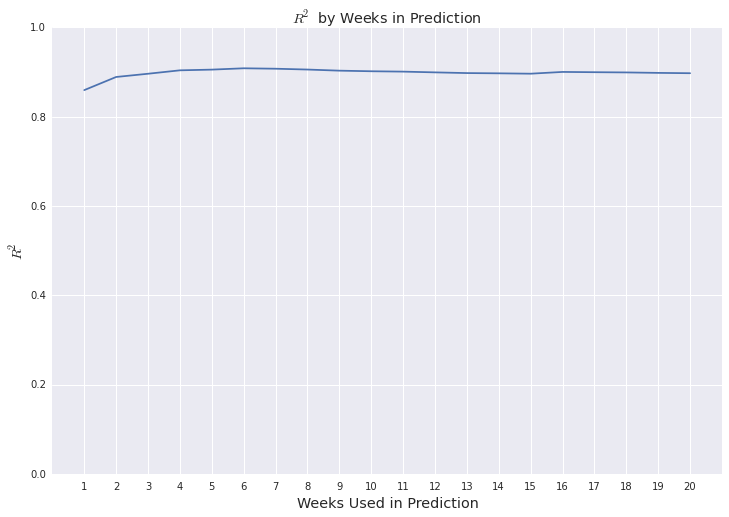

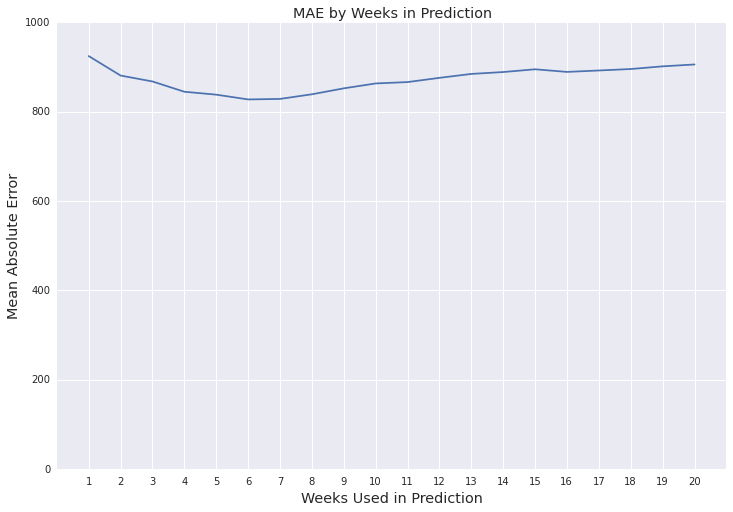

In [98]:
# Plot history for various metrics.

# R^2.
plt.figure(figsize=(12,8))
plt.plot(agg_scores['Weeks'], agg_scores['R^2'])
# Prettify.
plt.ylim((0,1)); plt.xlim((0,weeks_to_calculate+1))
plt.xticks(range(1,weeks_to_calculate+1))
plt.title('$R^2$ by Weeks in Prediction', fontsize='x-large')
plt.xlabel('Weeks Used in Prediction', fontsize='x-large')
plt.ylabel('$R^2$', fontsize='x-large')
# Show.
plt.show()

# MSE.
plt.figure(figsize=(12,8))
plt.plot(agg_scores['Weeks'], agg_scores['MAE'])
# Prettify.
plt.ylim((0,1000)); plt.xlim((0,weeks_to_calculate+1))
plt.xticks(range(1,weeks_to_calculate+1))
plt.title('MAE by Weeks in Prediction', fontsize='x-large')
plt.xlabel('Weeks Used in Prediction', fontsize='x-large')
plt.ylabel('Mean Absolute Error', fontsize='x-large')
# Show.
plt.show()

In [99]:
# Max R^2.
best_score_df = agg_scores[agg_scores['R^2'] == agg_scores['R^2'].max()]
best_weeks_for_r2 = int(best_score_df.Weeks[0])
best_score_df

,Weeks,R^2,MSE,MAE
0,6,0.9084,2698707.061646,827.428244


### By-Location Evaluations

In [100]:
# Container for R^2 scores.
by_location_scores = pd.DataFrame(columns=['locationid','Weeks','R^2','MSE','MAE'])

# Traverse all locations and generate scores by week.
for l in locationids:
    # Get subset of predictions for this location.
    loc_gatecount_predictions = gatecount_predictions.ix[gatecount_predictions.locationid == l,:]
    for w in xrange(1,weeks_to_calculate+1):
        # Find indices that are not null.
        non_null_indices = loc_gatecount_predictions[previous_weeks_prediction_col_prefix+str(w)].notnull()
        # Calculate evaluation scores.
        by_location_scores = by_location_scores.append([{
            'locationid': l,
            'Weeks': w,
            'Mean Entries': loc_gatecount_predictions.ix[non_null_indices, 'entries'].mean(),
            'R^2': sklearn.metrics.r2_score(
                loc_gatecount_predictions.ix[non_null_indices, 'entries'],
                loc_gatecount_predictions.ix[non_null_indices, previous_weeks_prediction_col_prefix+str(w)]
            ),
            'MSE': sklearn.metrics.mean_squared_error(
                loc_gatecount_predictions.ix[non_null_indices, 'entries'],
                loc_gatecount_predictions.ix[non_null_indices, previous_weeks_prediction_col_prefix+str(w)]
            ),
            'MAE': sklearn.metrics.mean_absolute_error(
                loc_gatecount_predictions.ix[non_null_indices, 'entries'],
                loc_gatecount_predictions.ix[non_null_indices, previous_weeks_prediction_col_prefix+str(w)]
            )
        }])

by_location_scores.head()

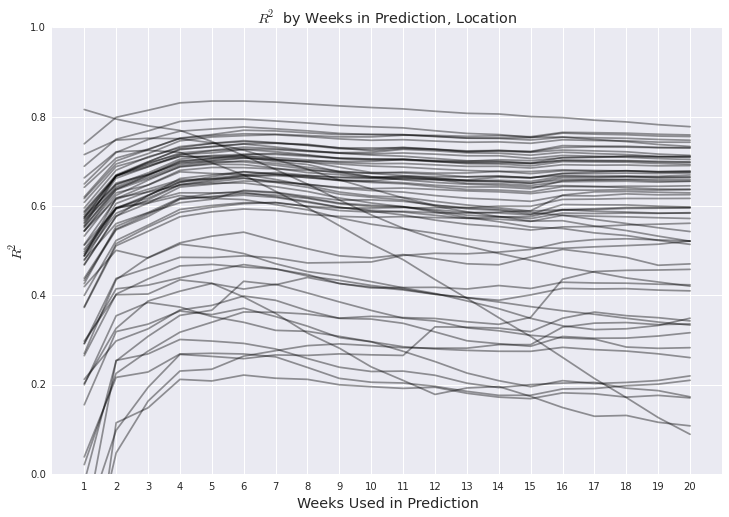

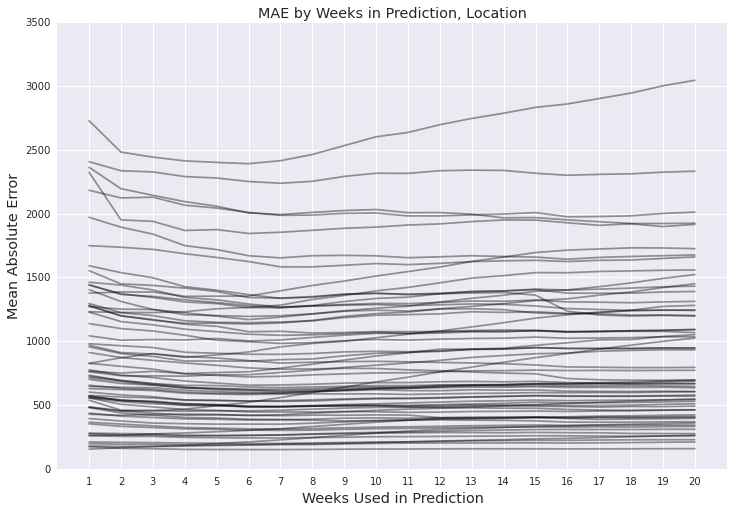

In [101]:
# Plot history for various metrics.

# R^2.
plt.figure(figsize=(12,8))
for l in locationids:
    plt.plot(
        by_location_scores.ix[by_location_scores.locationid == l,'Weeks'],
        by_location_scores.ix[by_location_scores.locationid == l,'R^2'],
        'k', alpha=0.4
    )
# Prettify.
plt.ylim((0,1)); plt.xlim((0,weeks_to_calculate+1))
plt.xticks(range(1,weeks_to_calculate+1))
plt.title('$R^2$ by Weeks in Prediction, Location', fontsize='x-large')
plt.xlabel('Weeks Used in Prediction', fontsize='x-large')
plt.ylabel('$R^2$', fontsize='x-large')
# Show.
plt.show()

# MAE.
plt.figure(figsize=(12,8))
for l in locationids:
    plt.plot(
        by_location_scores.ix[by_location_scores.locationid == l,'Weeks'],
        by_location_scores.ix[by_location_scores.locationid == l,'MAE'],
        'k', alpha=0.4
    )
# Prettify.
plt.xlim((0,weeks_to_calculate+1))
plt.xticks(range(1,weeks_to_calculate+1))
plt.title('MAE by Weeks in Prediction, Location', fontsize='x-large')
plt.xlabel('Weeks Used in Prediction', fontsize='x-large')
plt.ylabel('Mean Absolute Error', fontsize='x-large')
# Show.
plt.show()

Weird line is **Airport**. Still need to investigate why that is.

### Final Benchmarks by Location

In [120]:
# Get final R^2 scores at best week.
final_benchmark_score = by_location_scores.ix[by_location_scores.Weeks==best_weeks_for_r2,['locationid','R^2','Mean Entries','MAE']]
final_benchmark_score = final_benchmark_score.merge(stations)

# Clean up columns.
final_benchmark_score.rename(columns={'locationid':'Station #', 'name': 'Station Name', 'line': 'Main Line'}, inplace=True)
final_benchmark_score = final_benchmark_score.ix[:,[0,4,5,2,3,1]]

# Sort by entries.
final_benchmark_score.sort('R^2', inplace=True, ascending=False)
final_benchmark_score.reset_index(inplace=True, drop=True)

# Get rid of odd negative R^2 cases.
# final_benchmark_score = final_benchmark_score[final_benchmark_score['R^2'] > 0]

# Print useful info.
print 'Mean R^2: %.4f' % final_benchmark_score['R^2'].mean()

Mean R^2: 0.6097


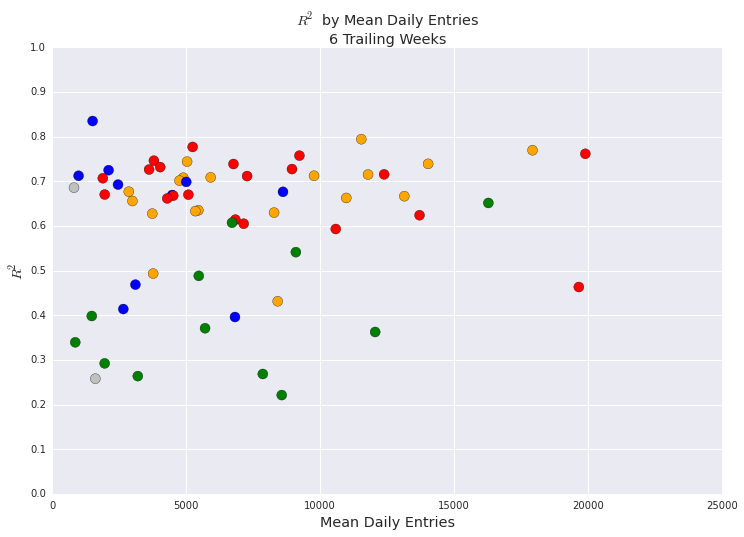

In [116]:
# R^2.
plt.figure(figsize=(12,8))
plt.scatter(final_benchmark_score['Mean Entries'], final_benchmark_score['R^2'], c=final_benchmark_score['Main Line'], s=100)
# Prettify.
plt.title('$R^2$ by Mean Daily Entries\n%d Trailing Weeks' % best_weeks_for_r2, fontsize='x-large')
plt.xlabel('Mean Daily Entries', fontsize='x-large')
plt.ylabel('$R^2$', fontsize='x-large')
plt.ylim(0,1)
plt.xlim(0, plt.xlim()[1])
plt.yticks(np.linspace(0,1,11))
# Show.
plt.show()

In [117]:
# Write CSV.
final_benchmark_score.to_csv('../../../data/prediction_baselines_per_station.csv', index=False)

In [109]:
# Output to browser.
final_benchmark_score

,Station #,Station Name,Main Line,Mean Entries,MAE,R^2
0,1019,Bowdoin,Blue,1501.379167,189.197824,0.835059
1,1077,State Street,Orange,11534.683128,1194.591449,0.794380
2,1005,North Quincy,Red,5236.701923,622.554533,0.777015
3,1039,Downtown Crossing,Orange,17926.643347,1670.642204,0.769645
4,1009,South Station,Red,19898.709191,2010.171239,0.761633
5,2106,Charles MGH,Red,9224.100137,996.670096,0.757550
6,1103,Quincy Adams,Red,3790.311385,487.076589,0.746241
7,1070,Oak Grove,Orange,5029.973829,611.036134,0.744224
8,1080,Back Bay,Orange,14029.548697,1365.746228,0.739126
9,1007,Quincy Center,Red,6760.941909,720.145182,0.738778
